In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "/workspaces/Recommenders-Systems/data"
books_path = os.path.join(data_dir,"merged_df.pkl")

In [4]:
books_df= pd.read_pickle(books_path)
books_df.head().to_dict()

{'User-ID': {0: 276726, 1: 276729, 2: 276729, 3: 276744, 4: 276747},
 'ISBN': {0: '0155061224',
  1: '052165615X',
  2: '0521795028',
  3: '038550120X',
  4: '0060517794'},
 'Book-Rating': {0: 5, 1: 3, 2: 6, 3: 7, 4: 9},
 'Book-Title': {0: 'Rites of Passage',
  1: 'Help!: Level 1',
  2: 'The Amsterdam Connection : Level 4 (Cambridge English Readers)',
  3: 'A Painted House',
  4: 'Little Altars Everywhere'},
 'Book-Author': {0: 'Judith Rae',
  1: 'Philip Prowse',
  2: 'Sue Leather',
  3: 'JOHN GRISHAM',
  4: 'Rebecca Wells'},
 'Year-Of-Publication': {0: '2001', 1: '1999', 2: '2001', 3: 2001, 4: 2003},
 'Publisher': {0: 'Heinle',
  1: 'Cambridge University Press',
  2: 'Cambridge University Press',
  3: 'Doubleday',
  4: 'HarperTorch'},
 'Image-URL-L': {0: 'http://images.amazon.com/images/P/0155061224.01.LZZZZZZZ.jpg',
  1: 'http://images.amazon.com/images/P/052165615X.01.LZZZZZZZ.jpg',
  2: 'http://images.amazon.com/images/P/0521795028.01.LZZZZZZZ.jpg',
  3: 'http://images.amazon.com/i

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

In [63]:


def load_data(file_path):
    return pd.read_pickle(file_path)

def preprocess_data(data):
    le_user = LabelEncoder()
    le_isbn = LabelEncoder()
    
    data['User-ID'] = le_user.fit_transform(data['User-ID'])
    data['ISBN'] = le_isbn.fit_transform(data['ISBN'])
    
    return data, le_user, le_isbn

def create_sparse_matrix(data):
    rows = data['User-ID'].values
    cols = data['ISBN'].values
    values = data['Book-Rating'].values
    
    return csr_matrix((values, (rows, cols)))

def train_svd(matrix, n_components=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    return svd.fit(matrix)

def train_knn(matrix, n_neighbors=20):
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    return knn.fit(matrix)

def evaluate_model_svd(model, test_matrix, batch_size=1000):
    total_mse = 0
    total_samples = 0
    
    for i in range(0, test_matrix.shape[0], batch_size):
        batch = test_matrix[i:i+batch_size]
        non_zero_mask = batch.nonzero()
        actual = batch.data
        user_factors = model.transform(batch)
        item_factors = model.components_[:, non_zero_mask[1]]
        predicted = np.sum(user_factors[non_zero_mask[0], :] * item_factors.T, axis=1)
        total_mse += np.sum((actual - predicted) ** 2)
        total_samples += len(actual)
    
    return np.sqrt(total_mse / total_samples)

def evaluate_model_knn(model, test_matrix, train_matrix, batch_size=1000):
    total_mse = 0
    total_samples = 0
    
    for i in range(0, test_matrix.shape[0], batch_size):
        batch = test_matrix[i:i+batch_size]
        non_zero_mask = batch.nonzero()
        actual = batch.data
        _, indices = model.kneighbors(batch)
        
        predicted = []
        for j, idx in enumerate(indices):
            user_ratings = train_matrix[idx].toarray()
            book_indices = non_zero_mask[1][non_zero_mask[0] == j]
            pred = user_ratings[:, book_indices].mean(axis=0)
            predicted.extend(pred)
        
        predicted = np.array(predicted)
        total_mse += np.sum((actual - predicted) ** 2)
        total_samples += len(actual)
    
    return np.sqrt(total_mse / total_samples)

def get_top_n_recommendations(model, user_vector, n=10):
    if isinstance(model, TruncatedSVD):
        if isinstance(user_vector, csr_matrix):
            user_vector = user_vector.toarray().flatten()
        user_factors = model.transform(user_vector.reshape(1, -1))
        user_ratings = user_factors.dot(model.components_)
    elif isinstance(model, NearestNeighbors):
        if isinstance(user_vector, csr_matrix):
            user_vector = user_vector.toarray().flatten()
        _, indices = model.kneighbors(user_vector.reshape(1, -1))
        user_ratings = matrix[indices.flatten()].mean(axis=0).A1
    
    top_n_indices = np.argsort(user_ratings.flatten())[-n:][::-1]
    return top_n_indices

In [48]:
print("Chargement des données...")
data = load_data(books_path)

print("Prétraitement des données...")
data, le_user, le_isbn = preprocess_data(data)

print("Création de la matrice creuse...")
matrix = create_sparse_matrix(data)

del data
import gc
gc.collect()

Chargement des données...
Prétraitement des données...
Création de la matrice creuse...


1633

In [55]:
print("Division des données...")
train_matrix, test_matrix = train_test_split(matrix, test_size=0.2, random_state=42)

print("Entraînement du modèle SVD...")
svd_model = train_svd(train_matrix)

print("Entraînement du modèle KNN...")
knn_model = train_knn(train_matrix)

Division des données...
Entraînement du modèle SVD...
Entraînement du modèle KNN...


In [56]:
print("Évaluation des modèles...")
svd_rmse = evaluate_model_svd(svd_model, test_matrix)
svd_rmse

Évaluation des modèles...


np.float64(7.750016227247428)

In [57]:
knn_rmse = evaluate_model_knn(knn_model, test_matrix, train_matrix)

In [59]:
print(f"SVD RMSE: {svd_rmse}")
print(f"KNN RMSE: {knn_rmse}")

SVD RMSE: 7.750016227247428
KNN RMSE: 7.188491281673265


In [60]:
user_id = 0
user_vector = matrix[user_id]

In [64]:
print(f"\nTop 10 recommandations pour l'utilisateur {user_id} (SVD):")
svd_recs = get_top_n_recommendations(svd_model, user_vector)
print(le_isbn.inverse_transform(svd_recs))


Top 10 recommandations pour l'utilisateur 0 (SVD):
['0312195516' '0385504209' '067976402X' '0446672211' '0452282829'
 '0452282152' '0375707972' '0316777722' '0385722206' '0156027321']


In [65]:
print(f"\nTop 10 recommandations pour l'utilisateur {user_id} (KNN):")
knn_recs = get_top_n_recommendations(knn_model, user_vector)
print(le_isbn.inverse_transform(knn_recs))


Top 10 recommandations pour l'utilisateur 0 (KNN):
['0618129022' '0553282476' '0140185003' '043935806X' '0895031957'
 '067972544X' '0441172717' '0671021001' '0439136369' '0441000916']


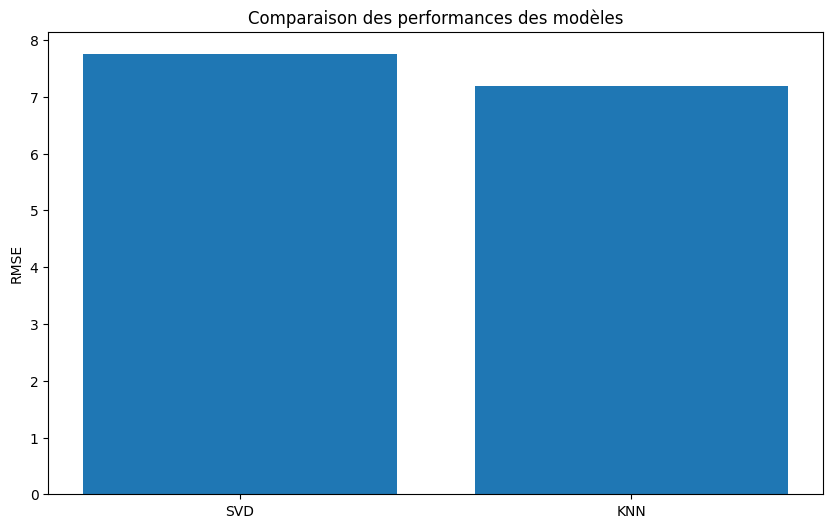

In [68]:
plt.figure(figsize=(10, 6))
plt.bar(['SVD', 'KNN'], [svd_rmse, knn_rmse])
plt.title('Comparaison des performances des modèles')
plt.ylabel('RMSE')
plt.show()